In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import numpy as np
import shutil
import torch
import random
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchvision import transforms,datasets, models, transforms
from torch.utils.data import TensorDataset,DataLoader, Dataset, WeightedRandomSampler
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
trainset="/kaggle/input/cats-and-dogs-image-classification/train"
testset="/kaggle/input/cats-and-dogs-image-classification/test"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), ( 0.5))
])
batch_size = 32

In [4]:
train_data = datasets.ImageFolder(root=trainset, transform=transform) 
test_data = datasets.ImageFolder(root=testset, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [5]:
class_names = train_data.classes
print("Class names: ",class_names)
print(len(class_names))

Class names:  ['cats', 'dogs']
2


Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


(-0.5, 223.5, 223.5, -0.5)

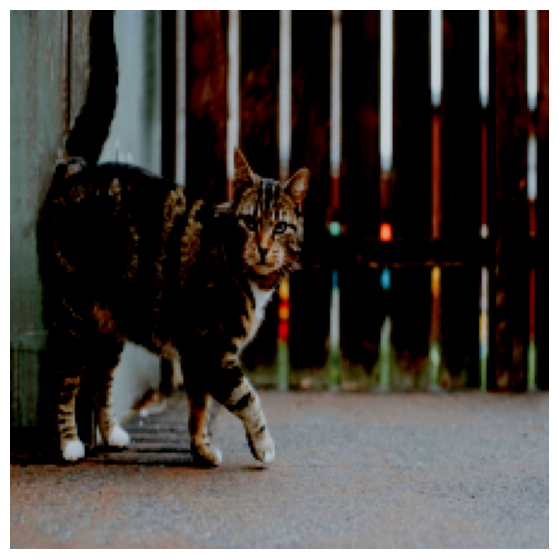

In [6]:
img,label = next(iter(train_data))
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")

In [8]:
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()

    test_loss, test_acc = 0, 0
    with torch.inference_mode():    
        for batch, (X, y) in enumerate(dataloader):            
            X, y = X.to(device), y.to(device)        
            test_pred_logits = model(X)            
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train(model: torch.nn.Module,train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),epochs: int = 5):

    results = {"train_loss": [],"train_acc": [],"test_loss": [],"test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,dataloader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,dataloader=test_dataloader,loss_fn=loss_fn)
        
        print( f"Epoch: {epoch+1} | "f"train_loss: {train_loss:.4f} | "f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "f"test_acc: {test_acc:.4f}" )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, stride=1, padding=1)        
        self.conv2 = nn.Conv2d(12, 36, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(72, 18, 3, stride=1, padding=1)  # 72 because concatenating two outputs of 36
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(14112, 120)  # Update this later if needed
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        y = self.pool(F.relu(self.conv2(x))) 
        z = self.pool(F.relu(self.conv2(x))) 
        x = torch.cat((y, z), dim=1)  
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
start_time = timer()

model_results = train(model=net,train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,optimizer=optimizer,
                      loss_fn=loss_fn,epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6966 | train_acc: 0.5118 | test_loss: 0.6913 | test_acc: 0.5375
Epoch: 2 | train_loss: 0.6858 | train_acc: 0.5644 | test_loss: 0.6917 | test_acc: 0.5542
Epoch: 3 | train_loss: 0.6773 | train_acc: 0.6194 | test_loss: 0.7389 | test_acc: 0.6542
Epoch: 4 | train_loss: 0.6720 | train_acc: 0.6436 | test_loss: 0.6782 | test_acc: 0.5729
Epoch: 5 | train_loss: 0.6450 | train_acc: 0.6306 | test_loss: 0.6977 | test_acc: 0.5729
Epoch: 6 | train_loss: 0.6156 | train_acc: 0.6671 | test_loss: 0.7207 | test_acc: 0.5563
Epoch: 7 | train_loss: 0.5753 | train_acc: 0.6946 | test_loss: 0.6839 | test_acc: 0.6229
Epoch: 8 | train_loss: 0.5455 | train_acc: 0.7302 | test_loss: 0.7017 | test_acc: 0.6062
Epoch: 9 | train_loss: 0.5302 | train_acc: 0.7399 | test_loss: 0.6652 | test_acc: 0.6958
Epoch: 10 | train_loss: 0.4872 | train_acc: 0.7529 | test_loss: 0.7215 | test_acc: 0.6104
Total training time: 95.110 seconds


In [9]:
def plot_loss_curves(results):
    results = dict(list(model_results.items()))    
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    
    epochs = range(len(results['train_loss']))    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
plot_loss_curves(model_results)